In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from binance.client import Client
from scipy.stats import norm
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
import re

# 🎯 Step 0: Instrument 파싱
def parse_instrument(row):
    match = re.match(r'BTC-(\d{1,2})([A-Z]{3})(\d{2})-(\d+)-(C|P)', row['instrument'], re.IGNORECASE)
    if not match:
        return pd.Series([np.nan]*3, index=['expiration', 'strike', 'option_type'])
    day, mon_str, year, strike, option_type = match.groups()
    exp = datetime.strptime(f"{day}{mon_str}{year}", "%d%b%y")
    strike = float(strike)
    option_type = 'call' if option_type.upper() == 'C' else 'put'
    return pd.Series([exp, strike, option_type], index=['expiration', 'strike', 'option_type'])

# 🎯 Step 1: 폴더 내 모든 옵션 CSV 병합
def load_option_data_from_folder(folder_path):
    dfs = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv") and file.startswith("BTC-"):
            df = pd.read_csv(os.path.join(folder_path, file))
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# 🎯 Step 2: Binance spot 가격 붙이기
def attach_binance_spot_prices(target_df, api_key, api_secret):
    client = Client(api_key, api_secret)
    start_time = target_df['timestamp'].min() - timedelta(minutes=5)
    end_time = target_df['timestamp'].max() + timedelta(minutes=5)

    klines = client.get_historical_klines("BTCUSDT", interval=Client.KLINE_INTERVAL_1MINUTE,
                                          start_str=start_time.strftime("%Y-%m-%d %H:%M:%S"),
                                          end_str=end_time.strftime("%Y-%m-%d %H:%M:%S"))
    spot_df = pd.DataFrame(klines, columns=[
        "timestamp", "open", "high", "low", "close", "volume", "close_time",
        "quote_asset_volume", "number_of_trades", "taker_buy_base",
        "taker_buy_quote", "ignore"
    ])
    spot_df['timestamp'] = pd.to_datetime(spot_df['timestamp'], unit='ms')
    spot_df['spot_price'] = spot_df['close'].astype(float)
    spot_df = spot_df[['timestamp', 'spot_price']]

    merged_df = pd.merge_asof(
        target_df.sort_values('timestamp'),
        spot_df.sort_values('timestamp'),
        on='timestamp',
        direction='backward'
    )
    return merged_df

# 🎯 Step 3: Black-Scholes 및 IV 계산
def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0 or S <= 0 or K <= 0:
        return np.nan
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(price, S, K, T, r, option_type='call'):
    try:
        return brentq(lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - price, 1e-6, 5.0)
    except:
        return np.nan

# 🎯 Step 4: 메인 실행
def process_vol_surface_from_folder(folder_path, api_key, api_secret):
    df = load_option_data_from_folder(folder_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # instrument 파싱
    parsed = df.apply(parse_instrument, axis=1)
    df = pd.concat([df, parsed], axis=1)
    df.dropna(subset=['expiration', 'strike', 'option_type'], inplace=True)

    # spot 붙이기
    df = attach_binance_spot_prices(df, api_key, api_secret)

    # T 계산
    df['T_days'] = (df['expiration'] - df['timestamp']).dt.total_seconds() / (60 * 60 * 24)
    df['T_years'] = df['T_days'] / 365

    # price 계산 방식: cost / volume 또는 close
    df['price'] = df.apply(lambda row: row['cost'] / row['volume'] if row['volume'] > 0 else row['close'], axis=1)

    r = 0.01  # risk-free rate
    df['IV'] = df.apply(lambda row: implied_volatility(
        price=row['price'],
        S=row['spot_price'],
        K=row['strike'],
        T=row['T_years'],
        r=r,
        option_type=row['option_type']
    ), axis=1)

    # 시각화
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['strike'], df['T_days'], df['IV'], c=df['IV'], cmap='plasma')

    ax.set_xlabel('Strike Price')
    ax.set_ylabel('Days to Expiration')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('BTC Option Volatility Surface')
    plt.tight_layout()
    plt.show()

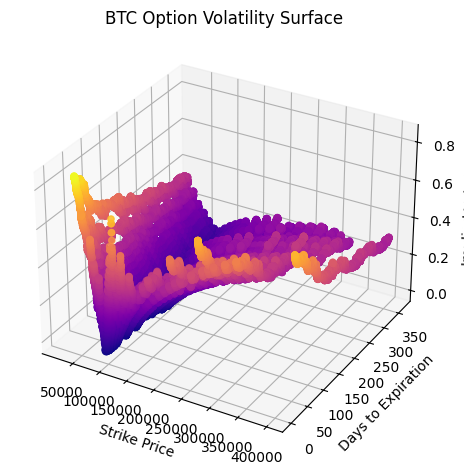

In [2]:
process_vol_surface_from_folder(
    folder_path='./by_instrument',
    api_key='zKyYTZWpQC9FfWlaWvbTLkeNENIPt8bBFIwJsMvl2x7pdeC5DI7YEQv9JzJpEEcW',
    api_secret='lLCEiIcWuip8k529JgBAWXMZXHVHmABTIfRK62oPFjslRhuZcfNmx2IrqwEC0VMH'
)